In [3]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model

In [4]:
# Define functions to load classes from the datasets
def load_classes_from_pest_dataset(dataset_dir):
    # Assuming classes are the subdirectory names in the dataset directory
    pest_classes = sorted(os.listdir(dataset_dir))
    return pest_classes

def load_classes_from_plant_disease_dataset(dataset_dir):
    # Assuming classes are the subdirectory names in the dataset directory
    plant_disease_classes = sorted(os.listdir(dataset_dir))
    return plant_disease_classes

# Load classes from the datasets
pest_classes = load_classes_from_pest_dataset("Documents/Pest_V2_one_group")
plant_disease_classes = load_classes_from_plant_disease_dataset("Downloads/RiceLeafDiseaseImages")

print("Pest Classes:", pest_classes)
print("Plant Disease Classes:", plant_disease_classes)

Pest Classes: ['asiatic rice borer', 'brown plant hopper', 'paddy stem maggot', 'rice gall midge', 'rice leaf caterpillar', 'rice leaf roller', 'rice leafhopper', 'rice water weevil', 'small brown plant hopper', 'yellow rice borer']
Plant Disease Classes: ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


In [28]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.models import Model

# Load the pre-trained efficientnet model
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define Swish activation using TensorFlow operations
def swish_activation(x):
    return tf.nn.sigmoid(x) * x

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Activation(swish_activation)(x)  # Applying Swish activation here
predictions = Dense(10, activation='softmax')(x)


# Create the final model
model_A = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_A.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_A.summary()

model_A.load_weights("best_model_pest.keras")

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 64)      │           1,728 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 64)      │             256 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 64)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 64)      │             576 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 64)      │             256 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 64)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 64)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 64)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 16)          │           1,040 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 64)          │           1,088 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_excite (Multiply)  │ (None, 112, 112, 64)      │               0 │ block1a_activation[0][0],  │
│                               │                           │                 │ block1a_se_expand[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 32)      │           2,048 │ block1a_se_excite[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 32)      │             128 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 64,426,778 (245.77 MB)

 Trainable params: 329,098 (1.26 MB)

 Non-trainable params: 64,097,680 (244.51 MB)

In [29]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model architecture
model_B = Sequential()
model_B.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_B.add(MaxPooling2D((2, 2)))
model_B.add(Conv2D(64, (3, 3), activation='relu'))
model_B.add(MaxPooling2D((2, 2)))
model_B.add(Flatten())
model_B.add(Dense(64, activation='relu'))
model_B.add(Dense(4, activation='softmax'))

# Compile the model
model_B.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_B.summary()

# Load the trained weights
model_B.load_weights("best_model_leaf.keras")

C:\Users\mhbra\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │      11,944,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,963,652 (45.64 MB)

 Trainable params: 11,963,652 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\mhbra\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [62]:
threshold = .90

In [63]:
def preprocess_image(image):
    # Convert the image to an array
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    # Expand the dimensions to create a batch of size 1
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the input image
    preprocessed_image = tf.keras.applications.resnet.preprocess_input(expanded_img_array)
    return preprocessed_image

In [64]:
def load_image(image_path, target_size=(224, 224)):
    # Load the image from the given path
    image = Image.open(image_path)
    # Convert the image to RGB mode if it has an alpha channel
    if image.mode != 'RGB':
        image = image.convert('RGB')
    # Resize the image to the target size
    resized_image = image.resize(target_size)
    return resized_image


In [65]:
def combined_model(image):
    preprocessed_image = preprocess_image(image)
    
    # Run Model A (Pest detection)
    predictions_A = model_A.predict(preprocessed_image)
    if predictions_A.ndim == 1:
        # If only one value is returned, treat it as the confidence score
        confidence_A = predictions_A[0]
        if confidence_A > threshold:
            # Model A is confident, classify according to its prediction
            predicted_class_A = pest_classes[np.argmax(predictions_A)]
            return predicted_class_A, confidence_A, "Pest"
    else:
        # Model A predictions contain multiple values, apply thresholding to each class
        predicted_classes_A_indices = [i for i, confidence in enumerate(predictions_A[0]) if confidence > threshold]
        if predicted_classes_A_indices:
            # At least one class prediction passes the threshold
            max_confidence_A = max(predictions_A[0][i] for i in predicted_classes_A_indices)
            predicted_classes_A = [pest_classes[i] for i in predicted_classes_A_indices]
            return predicted_classes_A, max_confidence_A, "Pest"

    # Pass the image to Model B (Leaf disease detection)
    predictions_B = model_B.predict(preprocessed_image)
    if predictions_B.ndim == 1:
        # If only one value is returned, treat it as the confidence score
        confidence_B = predictions_B[0]
        if confidence_B > threshold:
            # Model B is confident, classify as a leaf disease
            predicted_class_B = plant_disease_classes[np.argmax(predictions_B)]
            return predicted_class_B, confidence_B, "Leaf disease"
    else:
        # Model B predictions contain multiple values, apply thresholding to each class
        predicted_classes_B_indices = [i for i, confidence in enumerate(predictions_B[0]) if confidence > threshold]
        if predicted_classes_B_indices:
            # At least one class prediction passes the threshold
            max_confidence_B = max(predictions_B[0][i] for i in predicted_classes_B_indices)
            predicted_classes_B = [plant_disease_classes[i] for i in predicted_classes_B_indices]
            return predicted_classes_B, max_confidence_B, "Leaf disease"

    # Neither model is confident
    return None, 0.0, "Uncertain"

<b> Load the image you want to detect

In [66]:
# Define the file path to your image
image_path = "Documents/test/image1.png"

In [67]:
# Load and preprocess the image
image = load_image(image_path)

In [68]:
# Now you can pass this preprocessed image to your combined model for prediction
result = combined_model(image)
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Prediction: (['brown plant hopper'], 0.9939367, 'Pest')


<b> attempt to view multiple images with the predicted value

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


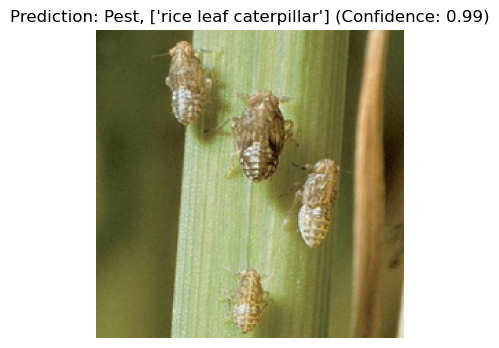

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


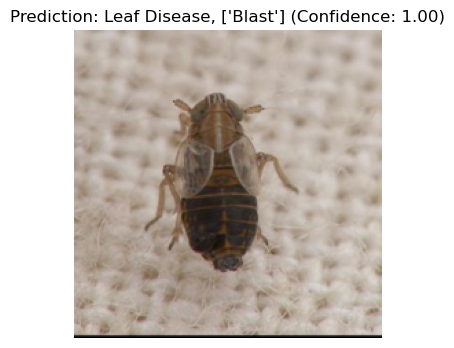

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


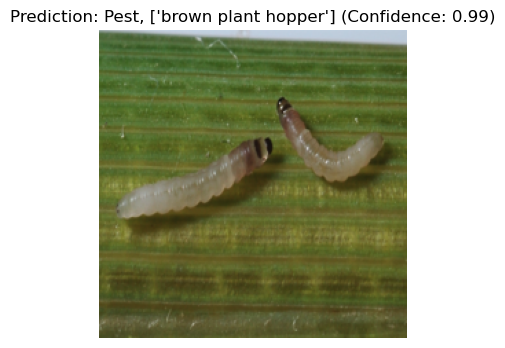

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


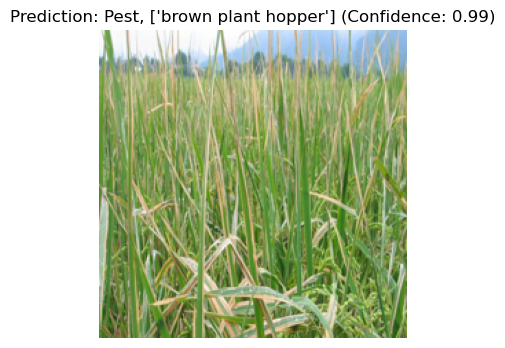

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


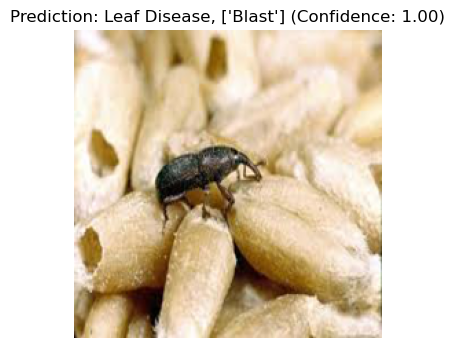

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


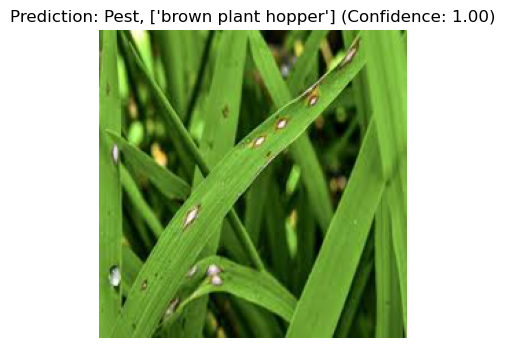

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


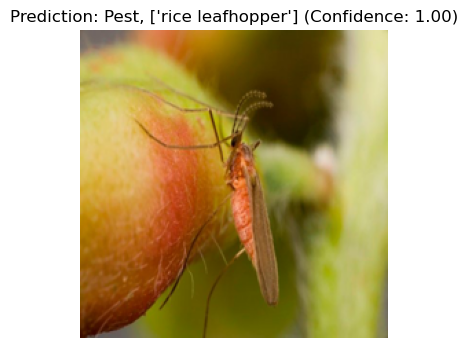

In [69]:
import os
import matplotlib.pyplot as plt

# Define the directory containing the images
image_dir = "Documents/test/"

# Get the list of all image file names in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Iterate over each image file
for image_file in image_files:
    # Construct the full path to the image
    image_path = os.path.join(image_dir, image_file)
    
    # Load and preprocess the image
    image = load_image(image_path)
    
    # Predict the class of the image and get the confidence score and model type
    predicted_class, confidence_score, model_type = combined_model(image)
    
    # Determine the class label (Pest or Leaf Disease)
    class_label = "Pest" if model_type == "Pest" else "Leaf Disease"
    
    # Display the image along with its predicted class (Pest or Leaf Disease), confidence score, and model type
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Prediction: {class_label}, {predicted_class} (Confidence: {confidence_score:.2f})")
    plt.axis('off')
    plt.show()